In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import skew
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import cross_val_score, train_test_split

### Load Features

##### Combine MEF data and temperature data into one dataframe

In [2]:
# Clean data so I have MEF for each region in a file with the region name 
region_df = pd.DataFrame()
nerc_regions = ['TRE', 'MRO', 'WECC', 'SPP', 'SERC', 'RFC', 'FRCC', 'NPCC']
for region in nerc_regions:
    print("currently processing " + region)
    region = 'TRE'
    # Add MEF data to df 
    for year in range(2012, 2018): 
        df = pd.read_csv("data/simulated/dispatch_output_weekly_" + region + "_" + str(year) + "_0co2_v27_coal_vom_same.csv")
        df = df[['datetime', 'co2_marg', 'so2_marg', 'nox_marg']]
        region_df = pd.concat((region_df, df))

    # Add temperature data 
    region_df['date'] = pd.DatetimeIndex(region_df['datetime']).normalize()
    temp_df = pd.read_csv("data/temperature/" + region + ".csv")
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    
    # Combine and save the df 
    result_df = pd.merge(temp_df, region_df)
    result_df = result_df[['datetime', 'co2_marg', 'so2_marg', 'nox_marg', 'maxTemp', 'minTemp']]
    result_df.to_csv("data/mefs/" + region + "_with_temp.csv")

currently processing TRE
currently processing MRO
currently processing WECC
currently processing SPP
currently processing SERC
currently processing RFC
currently processing FRCC
currently processing NPCC


##### Load Features for One Region

Extract information from datetime column (is_weekend, is_holiday, month, hour)

In [3]:
# Add columns: is_weekend, is_holiday, month, hour
# Start with TRE as an example

region = "TRE"
df = pd.read_csv("data/mefs/" + region + "_with_temp.csv", index_col=0)
df['datetime'] = pd.to_datetime(df['datetime'])

# Create column indicating if date is a weekend 
df['is_weekend'] = df['datetime'].apply(lambda x: x.weekday() >= 5)

# Create column indicating if date is a holiday 
holidays = USFederalHolidayCalendar().holidays(start='2012-1-31', end='2017-12-31')
df['is_holiday'] = df['datetime'].isin(holidays)

# Create column with month, and hour 
month_to_season = ['winter'] * 3 + ['trans'] + ['summer'] * 5 + ['trans'] + ['winter'] * 2
df['month'] = pd.DatetimeIndex(df.datetime).month 
df['hour'] = pd.DatetimeIndex(df.datetime).hour
df['year'] = pd.DatetimeIndex(df.datetime).year

# sin/cos correct of month and hour 
df['cos_month'] = np.cos((df.month)*(2*np.pi/12))
df['sin_month'] = np.sin((df.month)*(2*np.pi/12))
df['cos_hour'] = np.cos((df.hour)*(2*np.pi/12))
df['sin_hour'] = np.sin((df.hour)*(2*np.pi/12))

# Find average temperature between max and min 
df['avg_temp'] = df[['maxTemp', 'minTemp']].mean(axis=1)

df = df.drop(['month', 'hour', 'maxTemp', 'minTemp', 'datetime'], axis=1)

df

,co2_marg,so2_marg,nox_marg,is_weekend,is_holiday,year,cos_month,sin_month,cos_hour,sin_hour,avg_temp
0,369.328381,0.001866,0.102505,True,False,2012,0.866025,5.000000e-01,1.000000e+00,0.000000,43.43
1,380.870787,0.001924,0.035481,True,False,2012,0.866025,5.000000e-01,8.660254e-01,0.500000,43.43
2,985.614462,2.826002,0.663500,True,False,2012,0.866025,5.000000e-01,5.000000e-01,0.866025,43.43
3,380.870787,0.001924,0.035481,True,False,2012,0.866025,5.000000e-01,6.123234e-17,1.000000,43.43
4,369.015563,0.001864,0.099055,True,False,2012,0.866025,5.000000e-01,-5.000000e-01,0.866025,43.43
...,...,...,...,...,...,...,...,...,...,...,...
841723,394.666737,0.001994,0.081923,True,False,2017,1.000000,-2.449294e-16,-8.660254e-01,-0.500000,44.51
841724,1046.883693,3.660423,0.299980,True,False,2017,1.000000,-2.449294e-16,-5.000000e-01,-0.866025,44.51
841725,426.376950,0.002153,0.107935,True,False,2017,1.000000,-2.449294e-16,-4.286264e-16,-1.000000,44.51
841726,975.438518,5.927592,0.707773,True,False,2017,1.000000,-2.449294e-16,5.000000e-01,-0.866025,44.51


###  Data Exploration

##### Graph the dependent variables 

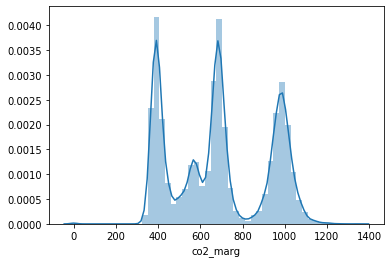

In [5]:
sns.distplot(df['co2_marg'])

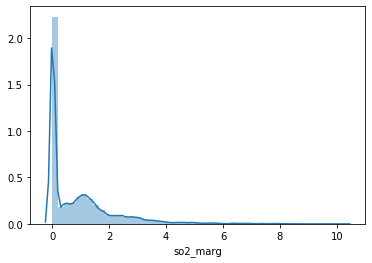

In [6]:
sns.distplot(df['so2_marg'])

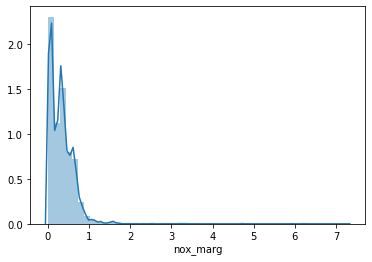

In [7]:
sns.distplot(df['nox_marg'])

##### Correlation Matrix

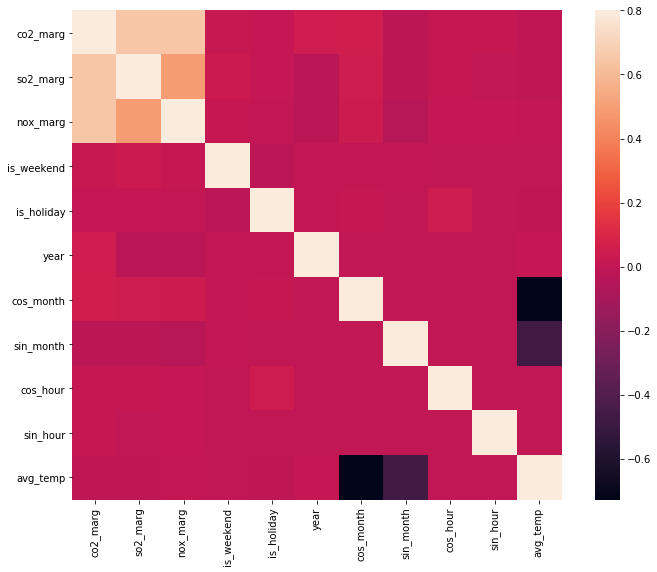

In [8]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [4]:
corr = df.corr()
corr.sort_values(["co2_marg"], ascending = False, inplace = True)
print(corr.co2_marg)

co2_marg      1.000000
so2_marg      0.647587
nox_marg      0.645533
cos_month     0.058944
year          0.053094
is_weekend    0.018881
sin_hour      0.015791
cos_hour      0.013842
is_holiday    0.010741
avg_temp     -0.006678
sin_month    -0.014373
Name: co2_marg, dtype: float64


### Regression

In [5]:
x = df.iloc[:,3:11]
y = df.iloc[:,0:3]

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 100) 

In [6]:
# Standardize numerical features
numerical_features = X_train.select_dtypes(exclude = ["object"]).columns

stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

/home/amy/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/amy/.local/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


##### Linear Regression 

In [23]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model, col):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train[col], scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model, col):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test[col], scoring = scorer, cv = 10))
    return(rmse)

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set\n")
print("CO2:", rmse_cv_train(lr, "co2_marg").mean())
print("SO2:", rmse_cv_train(lr, "so2_marg").mean())
print("NOX:", rmse_cv_train(lr, "nox_marg").mean())
print("RMSE on Test set\n")
print("CO2:", rmse_cv_test(lr, "co2_marg").mean())
print("SO2:", rmse_cv_test(lr, "so2_marg").mean())
print("NOX:", rmse_cv_test(lr, "nox_marg").mean())

RMSE on Training set

CO2: 230.0233941168463
SO2: 1.2585068046516816
NOX: 0.2953409922321949
RMSE on Test set

CO2: 230.15653301298053
SO2: 1.266118627571635
NOX: 0.2949691377008302


In [19]:
y_pred = lr.predict(X_test)
y_error = y_test - y_pred
y_error.median()

co2_marg   -16.222794
so2_marg    -0.473606
nox_marg    -0.034993
dtype: float64